In [62]:
import os
import sys
import pandas as pd
import numpy as np
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score, silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from matplotlib.ticker import FixedLocator, FixedFormatter
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for Kmeans memory leak

In [63]:
# !python -m spacy download de_core_news_sm 
# required to when setting runtime in addition to other package downloads

In [64]:
# Path to your CUDA binary directory for GPU acceleration
cuda_bin_path = "C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/bin"

# Add the path to the environment PATH variable
os.environ["PATH"] = cuda_bin_path + os.pathsep + os.environ["PATH"]

if torch.cuda.is_available():
    print(f"Cuda is available")
    device = torch.device("cuda")
else:
    print(f"Cuda is not available")
    device = torch.device("cpu")

# Ensure the NLTK resources and Lemmatizer resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('german')) 
nlp = spacy.load('de_core_news_sm')

#load the model for embedding
model_path = "ibm-granite/granite-embedding-107m-multilingual"
model = SentenceTransformer(model_path)
model = model.to(device)

# func to apply lemmatization with POS tagging using spaCy
def ngrams_with_lemmatization(n_grams):
    lemmatized_ngrams = []
    
    for ngram in n_grams:
        lemmatized_ngram = []
        # Process the ngram using spaCy
        doc = nlp(" ".join(ngram))  # Join the ngram into a single string and process
        
        for token in doc:
            # Skip stopwords, punctuation, and words with fewer than 2 characters
                # Lemmatize based on POS (spaCy automatically uses the correct lemma)
            lemmatized_ngram.append(token.lemma_)
        
        lemmatized_ngrams.append(lemmatized_ngram)
    return lemmatized_ngrams

def count_words_in_list(str_list, num=20):

    # Count the number of occurrences of each string
    string_count = Counter(str_list)

    # Order the count of strings by number of occurrences
    ordered_counts = string_count.most_common()

    # Display the ordered counts
    print(ordered_counts[:num])
    
def get_embedding(word):
    embedding = model.encode(word, device=device)  
    return np.squeeze(embedding)

def calculate_explained_variance_score(original_data, reconstructed_data):
    # Flatten the data to make sure we're comparing each feature across the samples
    original_data_flat = original_data.cpu().numpy()
    reconstructed_data_flat = reconstructed_data.cpu().numpy()
    
    # Compute the explained variance score
    evs = explained_variance_score(original_data_flat, reconstructed_data_flat)
    return evs

def kmeans_ksearch_plots(data, k_range = range(4,30)):
# Define the range of k values
    k_values = k_range
    # Initialize lists to store scores
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []

    # Calculate scores for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(data)
        y_pred = kmeans.labels_

        # Compute metrics
        silhouette_scores.append(silhouette_score(data, y_pred))
        calinski_harabasz_scores.append(calinski_harabasz_score(data, y_pred))
        davies_bouldin_scores.append(davies_bouldin_score(data, y_pred))

    # Plot the results
    plt.figure(figsize=(12, 8))

    # Silhouette Scores
    plt.subplot(3, 1, 1)
    plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different k')
    plt.grid(True)

    # Calinski-Harabasz Index
    plt.subplot(3, 1, 2)
    plt.plot(k_values, calinski_harabasz_scores, marker='o', color='green', label='Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title('Calinski-Harabasz Index for Different k')
    plt.grid(True)

    # Davies-Bouldin Index
    plt.subplot(3, 1, 3)
    plt.plot(k_values, davies_bouldin_scores, marker='o', color='red', label='Davies-Bouldin Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index for Different k')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def kmeans_ellbow_plot(data, k_range=range(4, 30)):
    # Calculate inertia for each k
    kmeans_per_k = [KMeans(n_clusters=k, n_init=40, random_state=42).fit(data) for k in k_range]
    inertias = [model.inertia_ for model in kmeans_per_k]

    # Plot inertia values
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertias, "bo-", label="Inertia")
    plt.xlabel("Number of Clusters ($k$)")
    plt.ylabel("Inertia")
    plt.title("Inertia vs. Number of Clusters ($k$)")
    plt.grid()

    # Dynamic axis limits
    plt.axis([4, np.max(k_range), 0, max(inertias) * 1.1])

    # Add legend and save the figure
    plt.legend()
    plt.show()

Cuda is available


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [65]:

# Path to the folder containing the txt files
folder_path = "Simulationen"

# List to collect rows
rows = []

# Iterate through all txt files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the file
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        
        for line in lines:
            # Split speaker and sentence if formatted like "P1: sentence"
            if ": " in line:
                speaker, content = line.split(": ", 1)
                # Tokenize the content into individual sentences
                sentences = sent_tokenize(content)
                for sentence in sentences:
                    # Append each sentence as a row
                    rows.append({"Speaker": speaker.strip(), "Sentence": sentence.strip()})

# Create DataFrame from collected rows
sentence_level_frame = pd.DataFrame(rows)

# Display the resulting DataFrame
print(sentence_level_frame.head(50))

   Speaker                                           Sentence
0       P1                                      Wer ist Pink?
1       P2                                   Bin beschäftigt!
2       P1  Okay, dann warte ich erstmal, ich bin bei dem ...
3       P3  Und wenn du wieder, wenn du wieder rein kommst...
4       P2                               Wie war, wo war der?
5       P1                                Lara, du bist Pink.
6       P2                                  Ne, ich bin Pink!
7       P1                                        Ah, Simone?
8       P1                    Ich bin draußen bei dem Grünen.
9       P1                         Ich bin jetzt ready, Lila.
10      P4                               Einmal zu Rosa raus.
11      P3                              Ah, du bist Rosa, P4?
12      P4  Ja, genau, aber ich muss erst mal schauen, wo ...
13      P1  Ich bin draußen und steh bei dem Grünen, aber ...
14      P1                            Was soll ich jetzt tun?
15      

In [66]:
word_rows = []
# Iterate through sentence-level DataFrame
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha() and word.lower() and word.lower() not in stop_words]
    # Append each word with its associated metadata
    for word in filtered_words:
        # Process each word with spaCy to get its lemma
        doc = nlp(word)
        lemmatized_word = doc[0].lemma_  # Getting the lemmatized version of the word
        word_rows.append({"Speaker": row["Speaker"], "Word": lemmatized_word})

# Create word-level DataFrame
word_level_frame_no_stopwords = pd.DataFrame(word_rows)

#same process with stopwords still included
word_rows = []
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha()]
    # Append each word with its associated metadata
    for word in filtered_words:
        # Process each word with spaCy to get its lemma
        doc = nlp(word)
        lemmatized_word = doc[0].lemma_  # Getting the lemmatized version of the word
        word_rows.append({"Speaker": row["Speaker"], "Word": lemmatized_word})
        
# Create word-level DataFrame
word_level_frame_with_stopwords = pd.DataFrame(word_rows)

# Display the resulting DataFrame
print(word_level_frame_no_stopwords.head(10))
print(word_level_frame_with_stopwords.head(10))

  Speaker          Word
0      P1           wer
1      P1          pink
2      P2  beschäftigen
3      P1          Okay
4      P1        warten
5      P1       erstmal
6      P1         grüne
7      P1       draußen
8      P3          rein
9      P3        kommst
  Speaker          Word
0      P1           wer
1      P1          sein
2      P1          pink
3      P2           Bin
4      P2  beschäftigen
5      P1          Okay
6      P1          dann
7      P1        warten
8      P1           ich
9      P1       erstmal


In [67]:


# Create bigrams
bigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 2)))

# Create trigrams
trigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams:", bigrams_with_stopwords)
print("Trigrams:", trigrams_with_stopwords)

# Create bigrams without stopwords
bigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 2)))

# Create trigrams without stopwords
trigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams without stopwords:", bigrams_no_stopwords)
print("Trigrams without stopwords:", trigrams_no_stopwords)


Bigrams: [['wer', 'sein'], ['sein', 'pink'], ['pink', 'Bin'], ['Bin', 'beschäftigen'], ['beschäftigen', 'Okay'], ['Okay', 'dann'], ['dann', 'warten'], ['warten', 'ich'], ['ich', 'erstmal'], ['erstmal', 'ich'], ['ich', 'sein'], ['sein', 'bei'], ['bei', 'der'], ['der', 'grüner'], ['grüne', 'draußen'], ['draußen', 'und'], ['und', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'rein'], ['rein', 'kommst'], ['kommsen', 'hier'], ['hier', 'links'], ['links', 'da'], ['da', 'hier'], ['hier', 'wie'], ['wie', 'sein'], ['sein', 'wo'], ['wo', 'sein'], ['sein', 'der'], ['der', 'Lara'], ['Lara', 'du'], ['du', 'sein'], ['sein', 'pink'], ['pink', 'Ne'], ['ne', 'ich'], ['ich', 'sein'], ['sein', 'pink'], ['Pink', 'Ah'], ['Ah', 'Simone'], ['Simone', 'ich'], ['ich', 'sein'], ['sein', 'draußen'], ['draußen', 'bei'], ['bei', 'der'], ['der', 'grüner'], ['grüne', 'ich'], ['ich', 'sein'], ['sein', 'jetzt'], ['jetzt', 'ready'], ['ready', 'Lila'], ['Lila

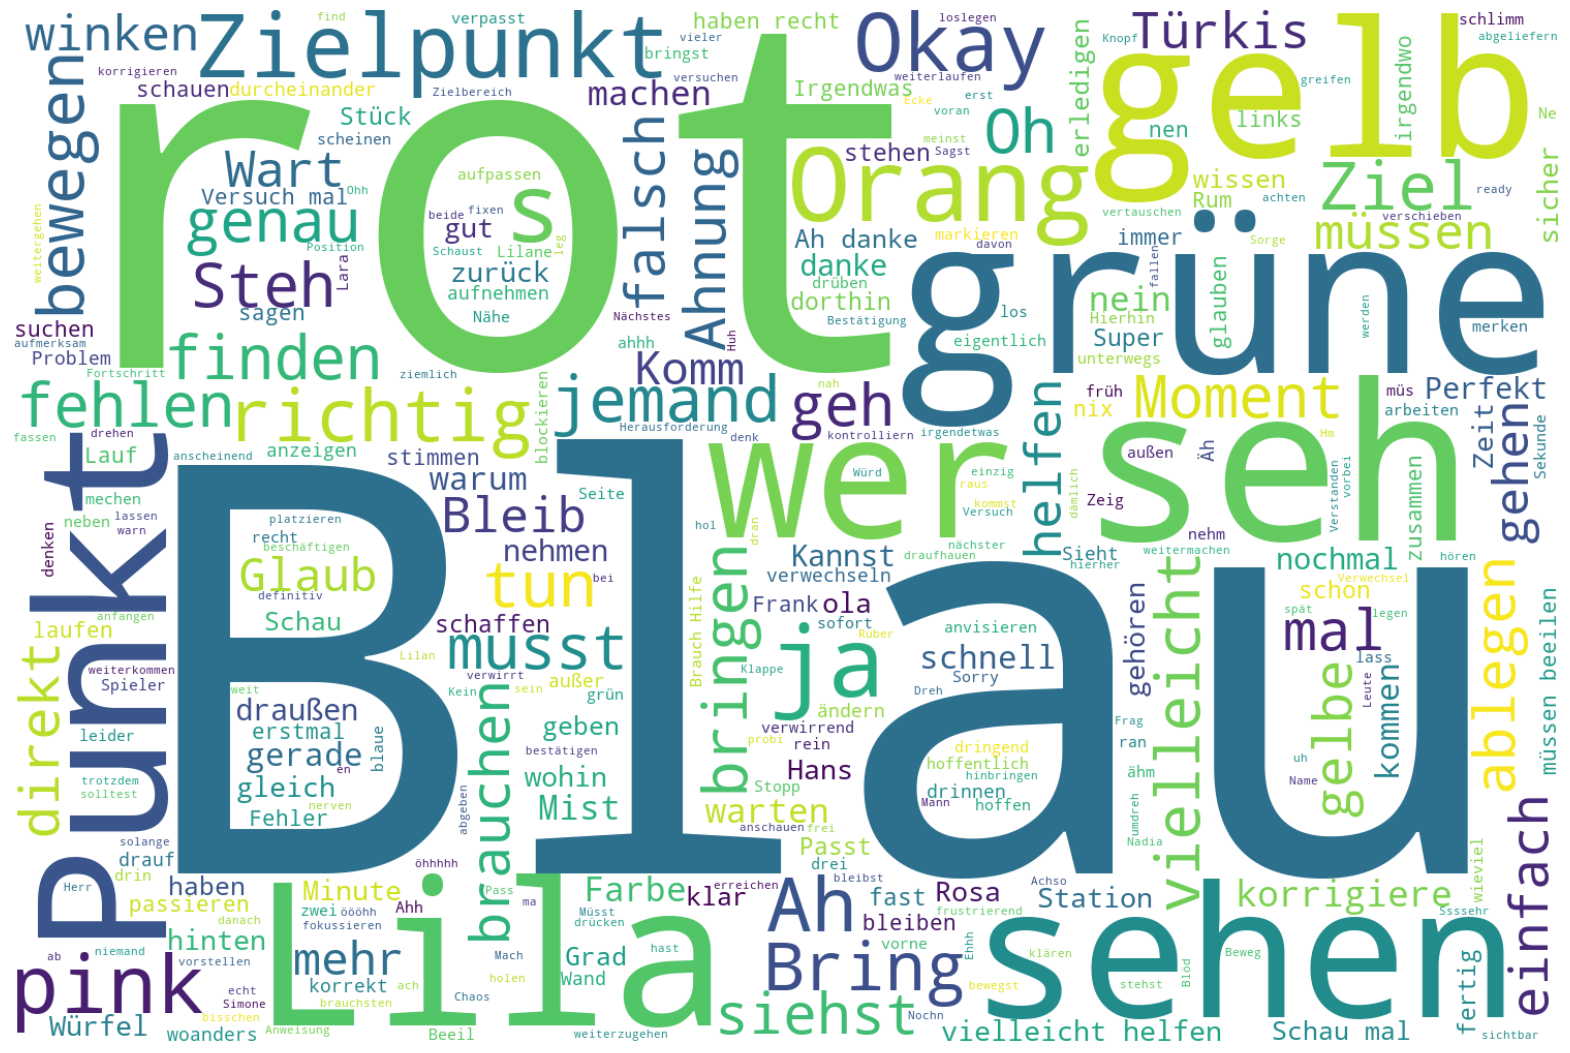

[('Blau', 120), ('rot', 87), ('seh', 79), ('grüne', 78), ('Lila', 66), ('gelb', 59), ('sehen', 55), ('Punkt', 53), ('wer', 50), ('Orang', 45), ('ja', 41), ('s', 39), ('Zielpunkt', 38), ('Ah', 34), ('pink', 29), ('Okay', 27), ('mal', 26), ('richtig', 26), ('vielleicht', 25), ('Bring', 22)]


In [68]:
def makeImage_uni(str_list):

    wc = WordCloud(width=1500, height=1000, background_color="white", max_words=400)
    # generate word cloud
    wc.generate(str_list)
   
    # show
    plt.figure( figsize=(20,20) )
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
makeImage_uni(' '.join(word_level_frame_no_stopwords["Word"].values))

count_words_in_list(word_level_frame_no_stopwords["Word"].values, 20)

Colours and verbs, not too interesting

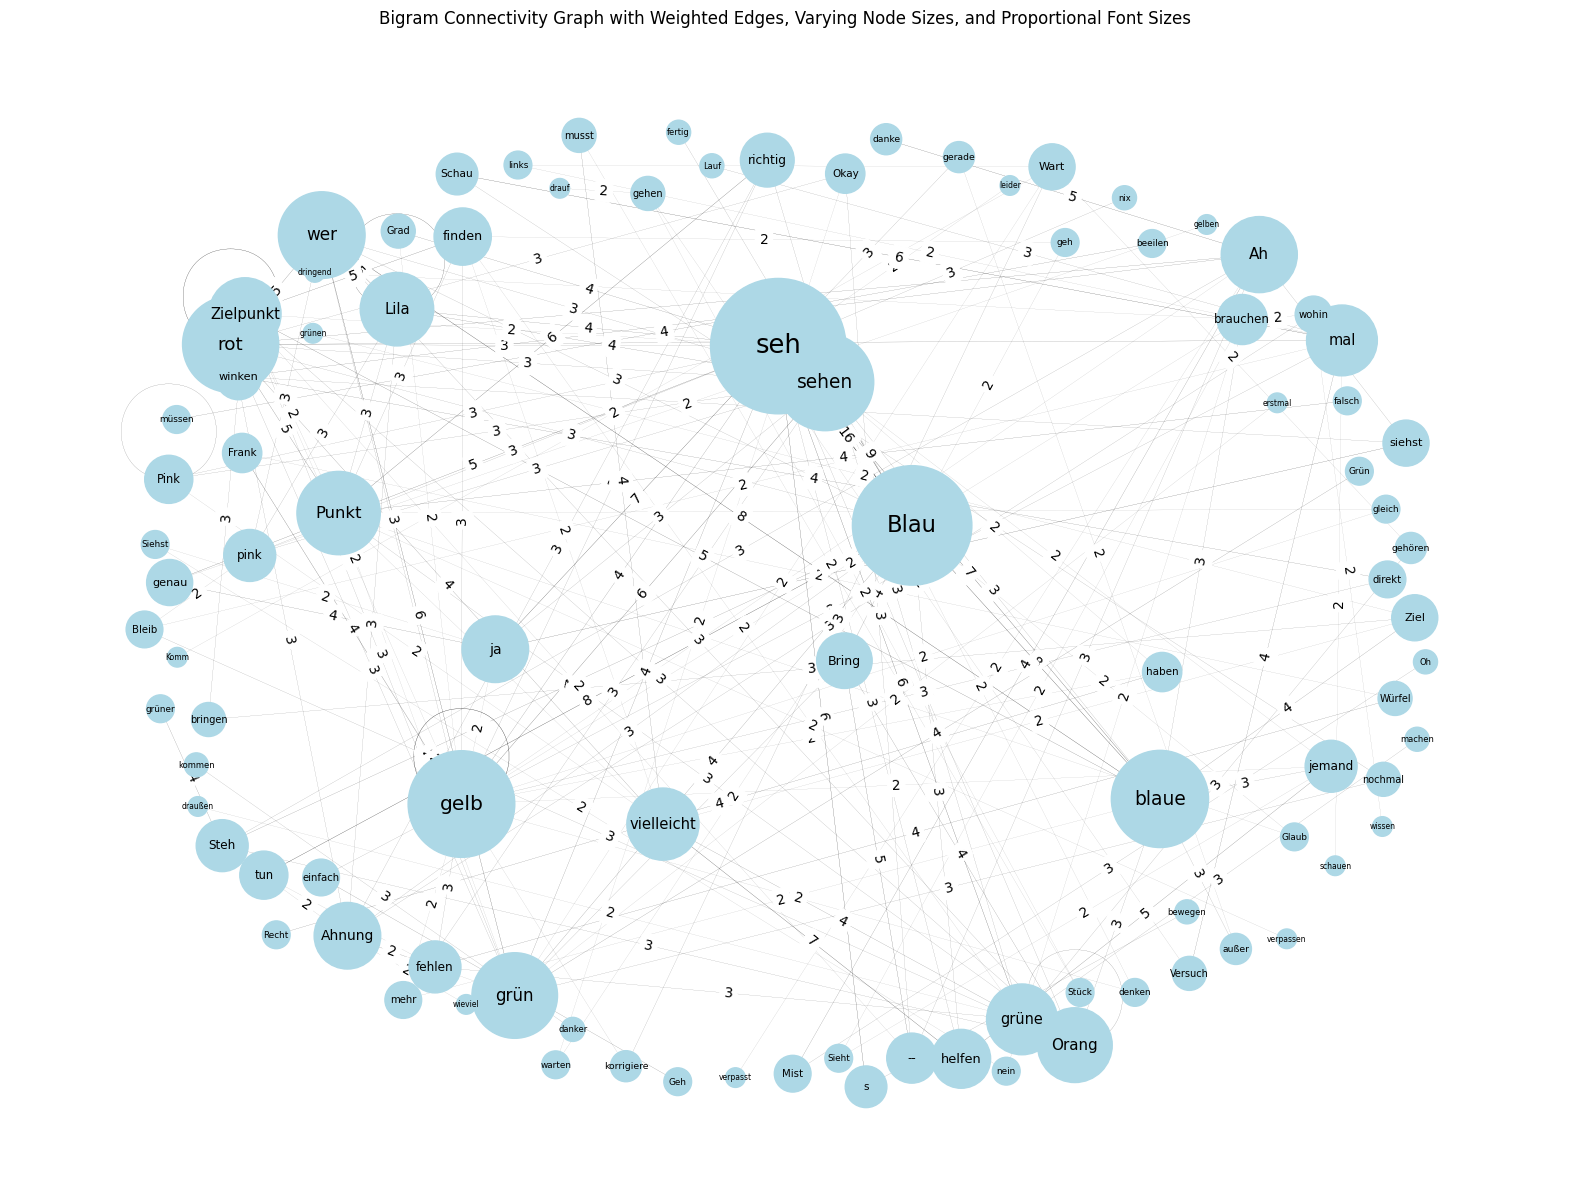

In [69]:
# Create a graph
G = nx.Graph()

bigram_tuples = [tuple(bigram) for bigram in bigrams_no_stopwords]

# Count frequencies of each bigram tuple
bigram_counts = Counter(bigram_tuples).most_common(200)
# Adding edges from the data
for (word1, word2), weight in bigram_counts:
    G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(20, 15))
# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42, k = 3)

# Calculate node sizes based on the sum of edge weights (scaled for visibility)
node_sizes = [sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()]
scaled_node_sizes = [size / 0.01 for size in node_sizes]  # Adjust size scale as needed

# Draw the nodes with increased size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=scaled_node_sizes)

# Draw the edges with varying width based on the weight
edge_widths = [G[u][v]['weight'] / 50 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths)

# Create a font size list based on node sizes (simple linear scaling)
font_sizes = [np.log(size)+0.05*size / 50 for size in scaled_node_sizes]  # Scale font size in relation to node size

# Draw labels for nodes with varying font sizes
for node, font_size in zip(G.nodes(), font_sizes):
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)

# Edge labels with weights
edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Bigram Connectivity Graph with Weighted Edges, Varying Node Sizes, and Proportional Font Sizes")
plt.axis('off')  # Turn off the axis
plt.show()

Nothing here either...
Before we start embedding, we want to check whether the model embeds the data as expected and preserves relatedness in meaning of words & sequences as measurable closeness in distance between these sequences.

In [70]:
#Let's start with some words
dog = get_embedding("Hund")
cat = get_embedding("Katze")
typically_german = get_embedding("Zahlungsverzug")

# Calculate the cosine similarity between the words
print(cosine_similarity(dog.reshape(1, -1), cat.reshape(1, -1)))
print(cosine_similarity(dog.reshape(1, -1), typically_german.reshape(1, -1)))
print(cosine_similarity(cat.reshape(1, -1), typically_german.reshape(1, -1)))
print("Words work as expected") #Side-Note: Cats are more likely to be behind on a payment than dogs as it seems hahahaha
print("")
# Calculate the cosine similarity between some sentences and do the same over again
sentence1 = get_embedding("Der Hund bellt.")
sentence2 = get_embedding("Die Katze schläft.")
sentence3 = get_embedding("Der Zahlungsverzug ist ein Problem.")

print(cosine_similarity(sentence1.reshape(1, -1), sentence2.reshape(1, -1)))
print(cosine_similarity(sentence1.reshape(1, -1), sentence3.reshape(1, -1)))
print(cosine_similarity(sentence2.reshape(1, -1), sentence3.reshape(1, -1)))
print("Sentences work as expected")


[[0.9038009]]
[[0.65881634]]
[[0.6671236]]
Words work as expected

[[0.8005184]]
[[0.53862524]]
[[0.53948593]]
Sentences work as expected


In [71]:

# Iterate through the DataFrame and get embeddings
word_embeddings_with_stopwords = word_level_frame_with_stopwords['Word'].apply(get_embedding)
word_embeddings_no_stopwords = word_level_frame_no_stopwords['Word'].apply(get_embedding)
sentence_embeddings = sentence_level_frame['Sentence'].apply(get_embedding)

wlf_sw = word_level_frame_with_stopwords.copy() #copy for later use

# Create new columns for each embedding dimension
embedding_columns = [f"embedding_{i}" for i in range(384)]

#concat with frames
word_level_frame_with_stopwords[embedding_columns] = pd.DataFrame(word_embeddings_with_stopwords.tolist(), index=word_level_frame_with_stopwords.index)
sentence_level_frame[embedding_columns] = pd.DataFrame(sentence_embeddings.tolist(), index=sentence_level_frame.index)
word_level_frame_no_stopwords[embedding_columns] = pd.DataFrame(word_embeddings_no_stopwords.tolist(), index=word_level_frame_no_stopwords.index)

In [72]:
columns_to_standardize = word_level_frame_with_stopwords.columns[2:]

# Initialize StandardScaler
word_scaler_stopwords = StandardScaler()
word_scaler_no_stopwords = StandardScaler()
sentence_scaler = StandardScaler()

# Fit and transform only the sliced columns
word_level_frame_with_stopwords[columns_to_standardize] = word_scaler_stopwords.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])
word_level_frame_no_stopwords[columns_to_standardize] = word_scaler_no_stopwords.fit_transform(word_level_frame_no_stopwords[columns_to_standardize])
sentence_level_frame[columns_to_standardize] = sentence_scaler.fit_transform(sentence_level_frame[columns_to_standardize])

Lets start with PCA

In [73]:
pca_word = PCA(n_components=20) # Let's reduce the dimensionality to 20 just as an arbitrary choice
X20D_word = pca_word.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}") 

pca_sentence = PCA(n_components=20)
X20D_sentence = pca_sentence.fit_transform(sentence_level_frame[columns_to_standardize])
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.5980258584022522
Preserved variance for sentences is 0.5802019238471985


~58% is quite a lot for a reduction by a factor of almost 20!
But we will not get too much form increasing the dimensions much further, let's test with double the amount

In [74]:
pca_word = PCA(n_components=40) # Let's reduce the dimensionality to 20 just as an arbitrary choice
pca_word.fit(word_level_frame_with_stopwords[columns_to_standardize])
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}") 

pca_sentence = PCA(n_components=40)
pca_sentence.fit(sentence_level_frame[columns_to_standardize])
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.7802345752716064
Preserved variance for sentences is 0.7580807209014893


40 dimensions is a lot though!Let's see how we do with 30

In [75]:
pca_word = PCA(n_components=30) # Let's reduce the dimensionality to 20 just as an arbitrary choice
X30D_word = StandardScaler().fit_transform(pca_word.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])) # Standardize the data
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}")

pca_sentence = PCA(n_components=30)
X30D_sentence = StandardScaler().fit_transform(pca_sentence.fit_transform(sentence_level_frame[columns_to_standardize]))
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.7074577212333679
Preserved variance for sentences is 0.6862636208534241


This could be an acceptable number, but kmeans doesnt fare particularly well with high dimensional data
Another approach I would like to try is LDA, see beneath

![WhatsApp Image 2025-01-07 at 18.56.28_2bbf4117.jpg](<attachment:WhatsApp Image 2025-01-07 at 18.56.28_2bbf4117.jpg>)
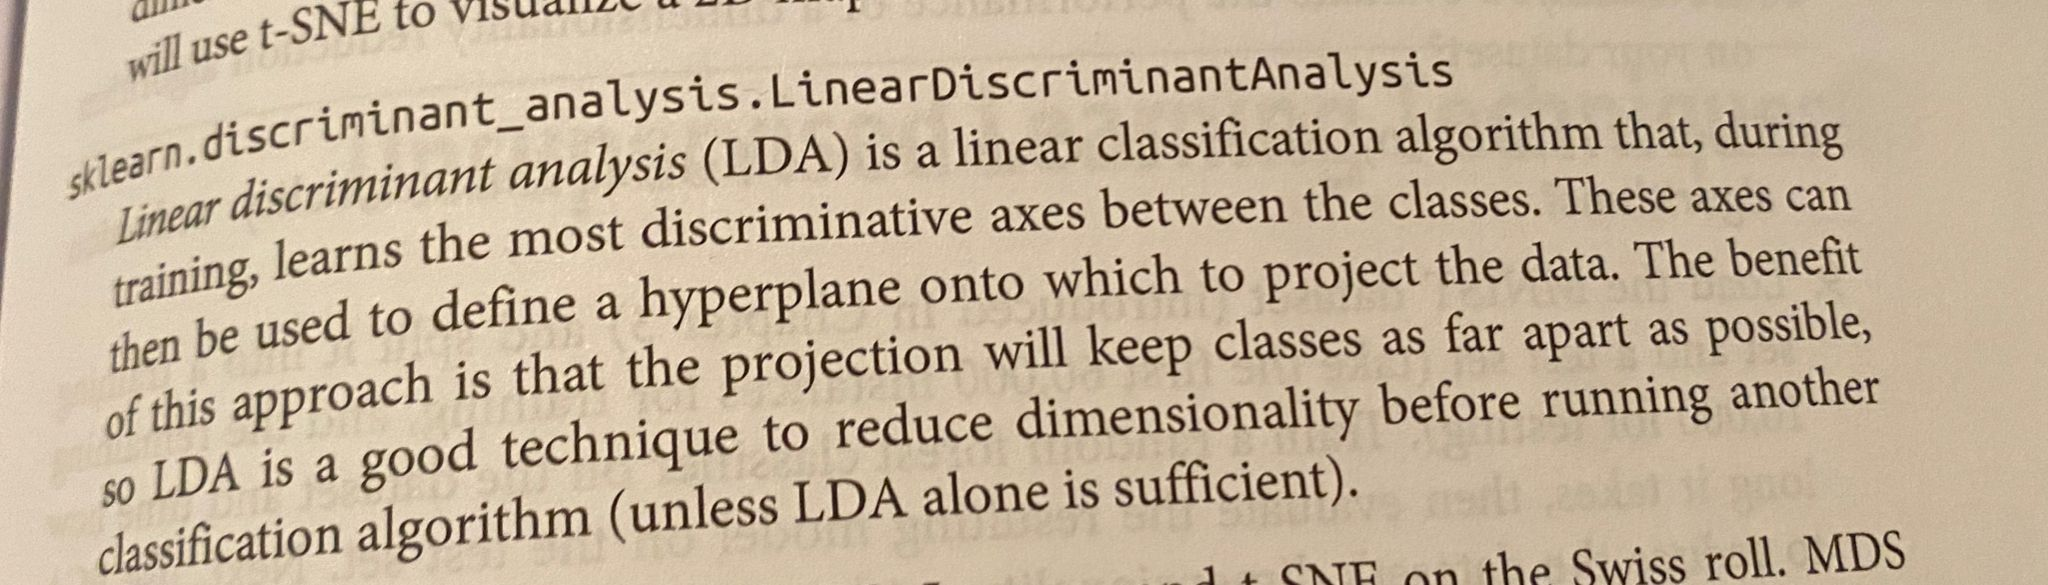

In [76]:
#following soon...maybe

A more sophisticated approach is the use of an Auto-Encoder architercture

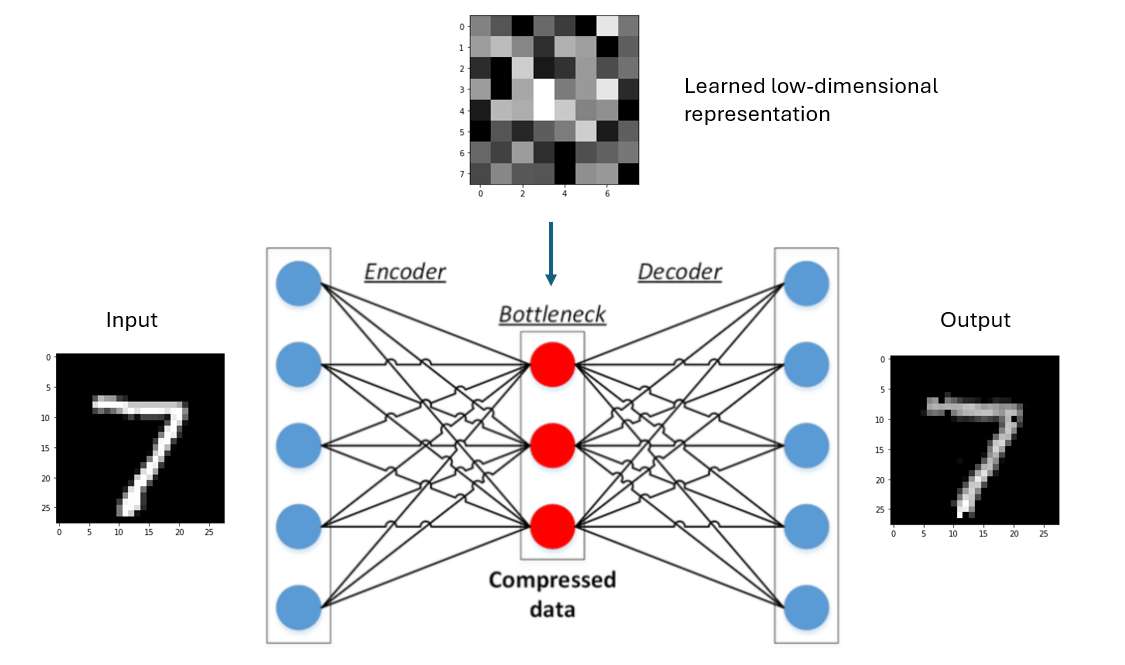 

In [77]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_size=384, latent_dim=3):
        super(Autoencoder, self).__init__()
         # Encoder with LayerNorm
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.LayerNorm(256),  # LayerNorm applied here
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),  # LayerNorm applied here
            nn.Linear(128, latent_dim)
        )
        
        # Decoder (could be symmetric or another design)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),  # LayerNorm applied here
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.LayerNorm(256),  # LayerNorm applied here
            nn.Linear(256, input_size)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [78]:

def train_and_infer_encoder(data, dims=3, path="best_autoencoder.pth"):
    # Convert to PyTorch tensor
    X_tensor = torch.tensor(data[columns_to_standardize].values, dtype=torch.float32)

    # Create a DataLoader for batching
    dataset = TensorDataset(X_tensor)
    # Create train/validation split
    dataset = TensorDataset(X_tensor)
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size  # 20% for validation
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Instantiate the encoder and move it to the GPU
    encoder = Autoencoder(latent_dim=dims).to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(encoder.parameters(), lr=0.001)

    # Early stopping and weight saving setup
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    patience_counter = 0
    best_model_path = path


    # Training loop with early stopping
    epochs = 1000
    for epoch in range(epochs):
        encoder.train()  # Ensure the encoder is in training mode
        train_loss = 0.0
        for batch in train_loader:
            # Get input data and move to GPU
            batch_X = batch[0].to(device)

            # Forward pass
            outputs = encoder(batch_X)
            loss = criterion(outputs, batch_X)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)  # Average loss over training batches

        # Validation loop
        encoder.eval()  # Switch to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch_X = batch[0].to(device)
                outputs = encoder(batch_X)
                loss = criterion(outputs, batch_X)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)  # Average loss over validation batches

        # Check for improvement
        if val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving encoder...")
            best_val_loss = val_loss
            torch.save(encoder.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training complete.")

    # Use the best encoder for inference
    loaded_model = Autoencoder(latent_dim=dims).to(device)
    loaded_model.load_state_dict(torch.load(best_model_path, weights_only=True))
    loaded_model.eval()  # Switch to evaluation mode
    print("Best encoder loaded.")

    #evaluate the model
    with torch.no_grad():
        # Using the entire dataset (X_tensor) for evaluation
        reconstructed_data = loaded_model(X_tensor.to(device))
        
        # Calculate the EVS for the best model
        evs = calculate_explained_variance_score(X_tensor, reconstructed_data)
        print(f"Explained Variance Score (EVS) for the Best Model: {evs:.4f}")

    # Example: Use the loaded encoder for inference
    with torch.no_grad():
        latent_representations = loaded_model.encoder(X_tensor.to(device)).cpu().numpy()
        print("Latent representations shape:", latent_representations.shape)
    return latent_representations

In [79]:
three_D_representations_word = train_and_infer_encoder(word_level_frame_with_stopwords[columns_to_standardize], dims=3) #model can be saved, but it is not necessary yet

Validation loss improved from inf to 0.6040. Saving encoder...
Epoch [1/1000] - Train Loss: 0.7692, Val Loss: 0.6040
Validation loss improved from 0.6040 to 0.4665. Saving encoder...
Epoch [2/1000] - Train Loss: 0.5314, Val Loss: 0.4665
Validation loss improved from 0.4665 to 0.3955. Saving encoder...
Epoch [3/1000] - Train Loss: 0.4252, Val Loss: 0.3955
Validation loss improved from 0.3955 to 0.3402. Saving encoder...
Epoch [4/1000] - Train Loss: 0.3679, Val Loss: 0.3402
Validation loss improved from 0.3402 to 0.3072. Saving encoder...
Epoch [5/1000] - Train Loss: 0.3233, Val Loss: 0.3072
Validation loss improved from 0.3072 to 0.2804. Saving encoder...
Epoch [6/1000] - Train Loss: 0.2910, Val Loss: 0.2804
Validation loss improved from 0.2804 to 0.2637. Saving encoder...
Epoch [7/1000] - Train Loss: 0.2643, Val Loss: 0.2637
Validation loss improved from 0.2637 to 0.2477. Saving encoder...
Epoch [8/1000] - Train Loss: 0.2574, Val Loss: 0.2477
Validation loss improved from 0.2477 to 0.2

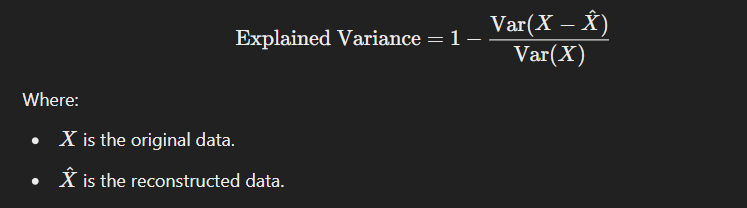

The information lost during encoding only accounts for 7% of the original variance!
Cool stuff 😎

In [80]:
#lets's still try with 10 dimensions, as well as with and without stopwords
ten_D_representations_word = train_and_infer_encoder(word_level_frame_with_stopwords[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.4102. Saving encoder...
Epoch [1/1000] - Train Loss: 0.6424, Val Loss: 0.4102
Validation loss improved from 0.4102 to 0.2812. Saving encoder...
Epoch [2/1000] - Train Loss: 0.3325, Val Loss: 0.2812
Validation loss improved from 0.2812 to 0.2177. Saving encoder...
Epoch [3/1000] - Train Loss: 0.2393, Val Loss: 0.2177
Validation loss improved from 0.2177 to 0.1925. Saving encoder...
Epoch [4/1000] - Train Loss: 0.1990, Val Loss: 0.1925
Validation loss improved from 0.1925 to 0.1611. Saving encoder...
Epoch [5/1000] - Train Loss: 0.1695, Val Loss: 0.1611
Validation loss improved from 0.1611 to 0.1423. Saving encoder...
Epoch [6/1000] - Train Loss: 0.1410, Val Loss: 0.1423
Validation loss improved from 0.1423 to 0.1292. Saving encoder...
Epoch [7/1000] - Train Loss: 0.1209, Val Loss: 0.1292
Validation loss improved from 0.1292 to 0.1187. Saving encoder...
Epoch [8/1000] - Train Loss: 0.1084, Val Loss: 0.1187
Validation loss improved from 0.1187 to 0.1

In [81]:
three_D_representations_word_no_stopwords = train_and_infer_encoder(word_level_frame_no_stopwords[columns_to_standardize], dims=3)

Validation loss improved from inf to 0.7817. Saving encoder...
Epoch [1/1000] - Train Loss: 0.9426, Val Loss: 0.7817
Validation loss improved from 0.7817 to 0.6400. Saving encoder...
Epoch [2/1000] - Train Loss: 0.7285, Val Loss: 0.6400
Validation loss improved from 0.6400 to 0.5573. Saving encoder...
Epoch [3/1000] - Train Loss: 0.6147, Val Loss: 0.5573
Validation loss improved from 0.5573 to 0.4991. Saving encoder...
Epoch [4/1000] - Train Loss: 0.5435, Val Loss: 0.4991
Validation loss improved from 0.4991 to 0.4568. Saving encoder...
Epoch [5/1000] - Train Loss: 0.4900, Val Loss: 0.4568
Validation loss improved from 0.4568 to 0.4246. Saving encoder...
Epoch [6/1000] - Train Loss: 0.4461, Val Loss: 0.4246
Validation loss improved from 0.4246 to 0.4019. Saving encoder...
Epoch [7/1000] - Train Loss: 0.4159, Val Loss: 0.4019
Validation loss improved from 0.4019 to 0.3825. Saving encoder...
Epoch [8/1000] - Train Loss: 0.3896, Val Loss: 0.3825
Validation loss improved from 0.3825 to 0.3

In [82]:
ten_D_representations_word_no_stopwords = train_and_infer_encoder(word_level_frame_no_stopwords[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.6256. Saving encoder...
Epoch [1/1000] - Train Loss: 0.8288, Val Loss: 0.6256
Validation loss improved from 0.6256 to 0.4671. Saving encoder...
Epoch [2/1000] - Train Loss: 0.5141, Val Loss: 0.4671
Validation loss improved from 0.4671 to 0.3823. Saving encoder...
Epoch [3/1000] - Train Loss: 0.3902, Val Loss: 0.3823
Validation loss improved from 0.3823 to 0.3279. Saving encoder...
Epoch [4/1000] - Train Loss: 0.3183, Val Loss: 0.3279
Validation loss improved from 0.3279 to 0.2933. Saving encoder...
Epoch [5/1000] - Train Loss: 0.2712, Val Loss: 0.2933
Validation loss improved from 0.2933 to 0.2661. Saving encoder...
Epoch [6/1000] - Train Loss: 0.2368, Val Loss: 0.2661
Validation loss improved from 0.2661 to 0.2453. Saving encoder...
Epoch [7/1000] - Train Loss: 0.2087, Val Loss: 0.2453
Validation loss improved from 0.2453 to 0.2293. Saving encoder...
Epoch [8/1000] - Train Loss: 0.1850, Val Loss: 0.2293
Validation loss improved from 0.2293 to 0.2

How about sentences?

In [83]:
three_D_representations_sentence = train_and_infer_encoder(sentence_level_frame[columns_to_standardize], dims=3)

Validation loss improved from inf to 0.9780. Saving encoder...
Epoch [1/1000] - Train Loss: 1.0713, Val Loss: 0.9780
Validation loss improved from 0.9780 to 0.9050. Saving encoder...
Epoch [2/1000] - Train Loss: 0.9138, Val Loss: 0.9050
Validation loss improved from 0.9050 to 0.8586. Saving encoder...
Epoch [3/1000] - Train Loss: 0.8462, Val Loss: 0.8586
Validation loss improved from 0.8586 to 0.8269. Saving encoder...
Epoch [4/1000] - Train Loss: 0.8057, Val Loss: 0.8269
Validation loss improved from 0.8269 to 0.8052. Saving encoder...
Epoch [5/1000] - Train Loss: 0.7767, Val Loss: 0.8052
Validation loss improved from 0.8052 to 0.7886. Saving encoder...
Epoch [6/1000] - Train Loss: 0.7525, Val Loss: 0.7886
Validation loss improved from 0.7886 to 0.7732. Saving encoder...
Epoch [7/1000] - Train Loss: 0.7337, Val Loss: 0.7732
Validation loss improved from 0.7732 to 0.7596. Saving encoder...
Epoch [8/1000] - Train Loss: 0.7168, Val Loss: 0.7596
Validation loss improved from 0.7596 to 0.7

Not too good, but let's still take a look at the compressed data later on

In [84]:
#choose 10D representation of the sentence instead
ten_D_representations_sentence =train_and_infer_encoder(sentence_level_frame[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.8872. Saving encoder...
Epoch [1/1000] - Train Loss: 1.0518, Val Loss: 0.8872
Validation loss improved from 0.8872 to 0.7748. Saving encoder...
Epoch [2/1000] - Train Loss: 0.8047, Val Loss: 0.7748
Validation loss improved from 0.7748 to 0.7108. Saving encoder...
Epoch [3/1000] - Train Loss: 0.7033, Val Loss: 0.7108
Validation loss improved from 0.7108 to 0.6720. Saving encoder...
Epoch [4/1000] - Train Loss: 0.6423, Val Loss: 0.6720
Validation loss improved from 0.6720 to 0.6451. Saving encoder...
Epoch [5/1000] - Train Loss: 0.6001, Val Loss: 0.6451
Validation loss improved from 0.6451 to 0.6256. Saving encoder...
Epoch [6/1000] - Train Loss: 0.5683, Val Loss: 0.6256
Validation loss improved from 0.6256 to 0.6076. Saving encoder...
Epoch [7/1000] - Train Loss: 0.5413, Val Loss: 0.6076
Validation loss improved from 0.6076 to 0.5954. Saving encoder...
Epoch [8/1000] - Train Loss: 0.5190, Val Loss: 0.5954
Validation loss improved from 0.5954 to 0.5

Time for some clustering. Let's start with k-means

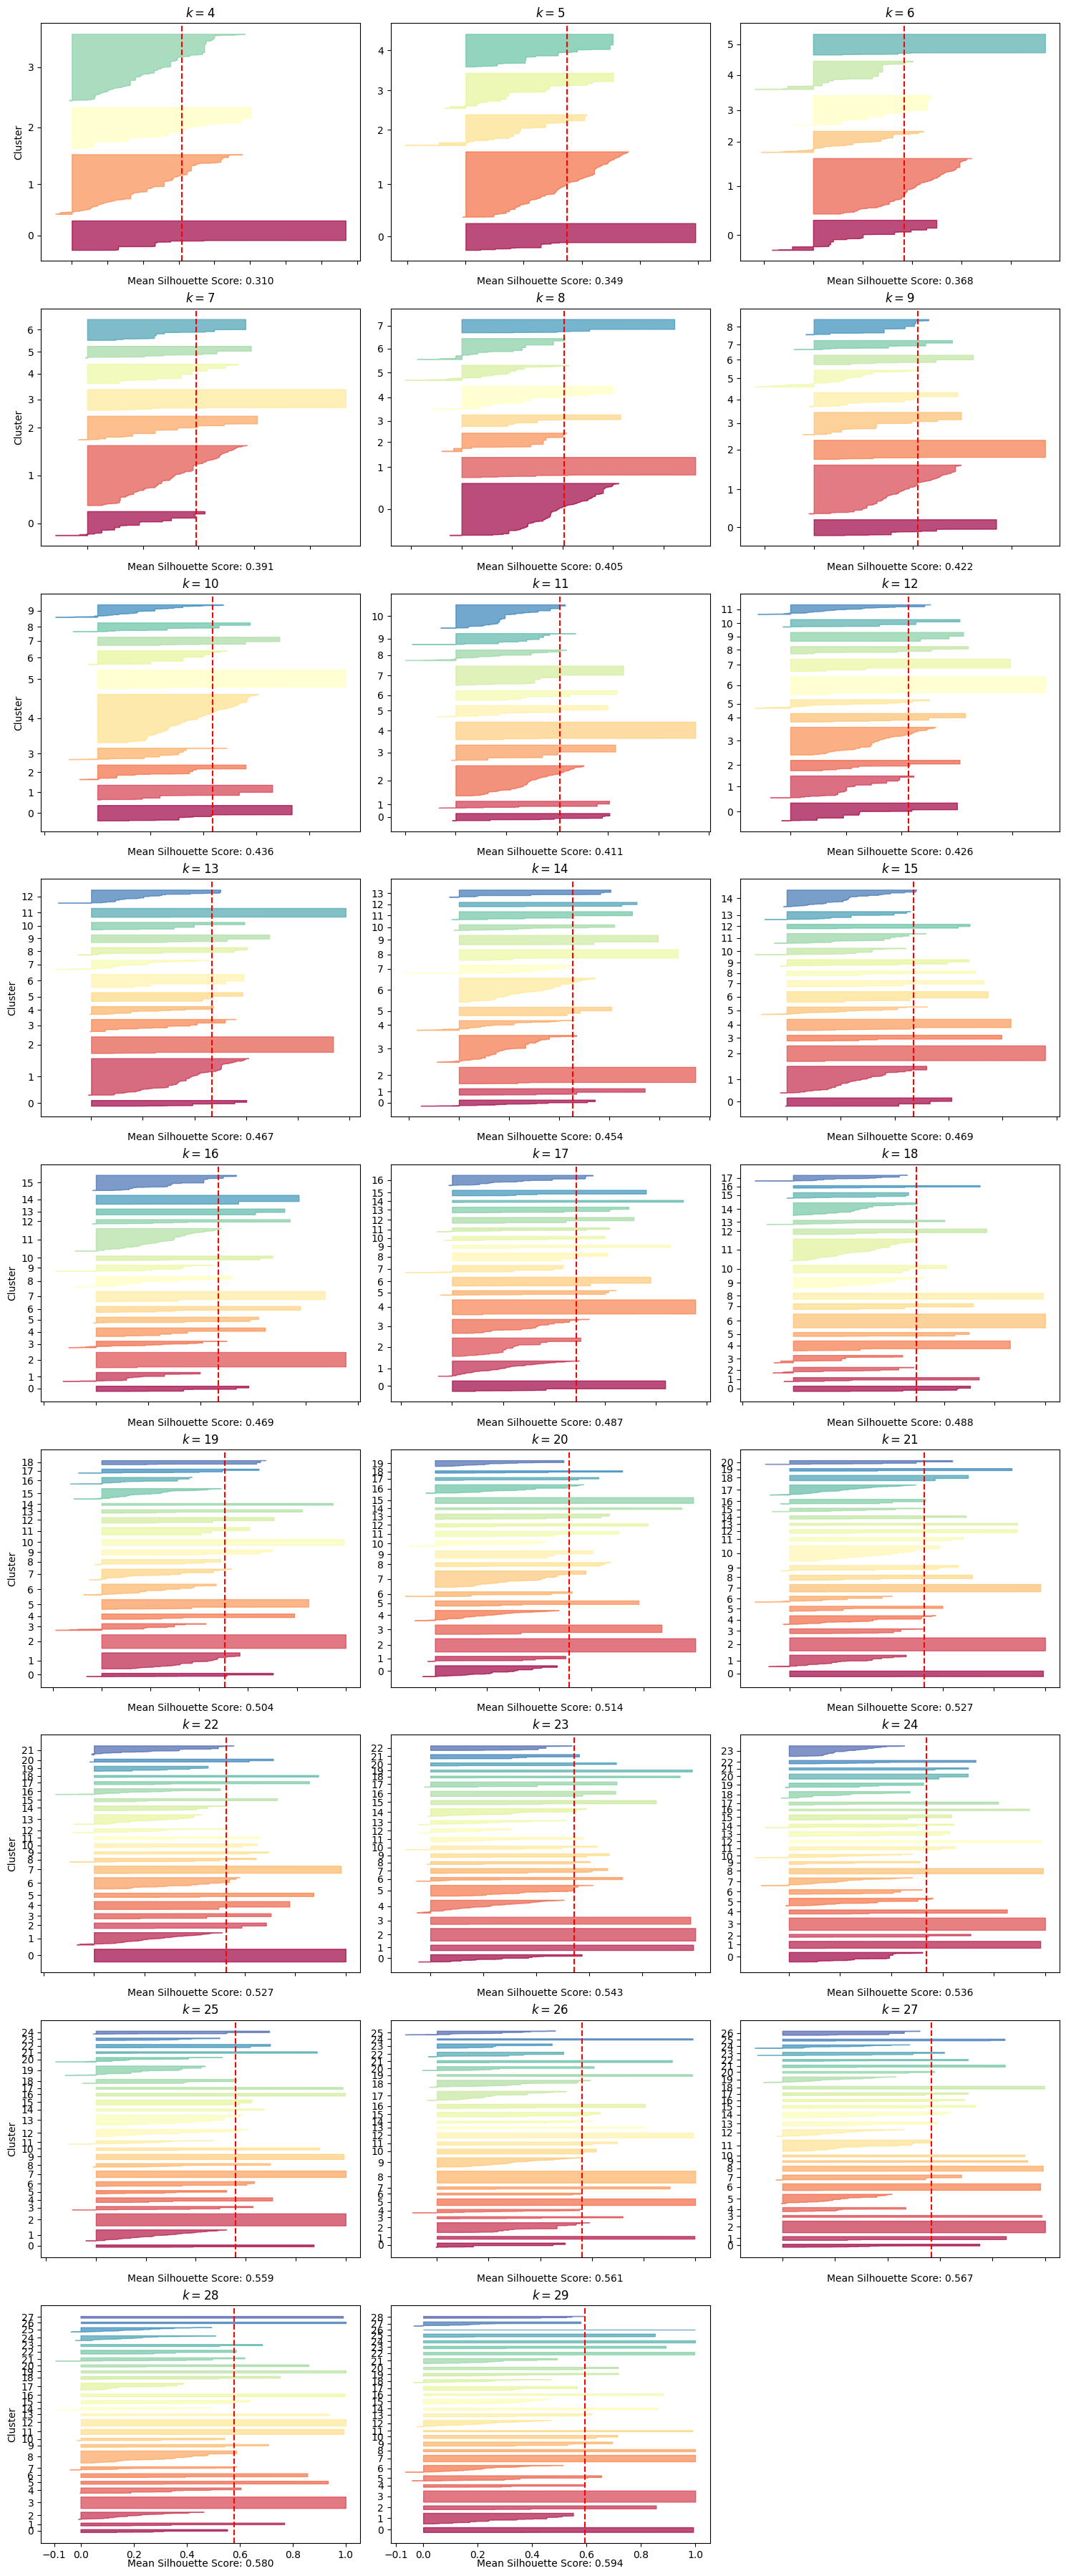

In [85]:
# A hyperparameter search for the best number of clusters
range_n_clusters = range(4, 30)  # Set the range of clusters you want to test
kmeans_per_k = [KMeans(n_clusters=k, n_init=40, random_state=42).fit(three_D_representations_word) for k in range_n_clusters]
silhouette_scores = [silhouette_score(three_D_representations_word, model.labels_) for model in kmeans_per_k]

# Define the range of k values to visualize
k_values = range_n_clusters  # Modify this range as needed

# Dynamically calculate the number of rows and columns for subplots
num_k = len(k_values)
num_cols = 3  # Set the number of columns you want
num_rows = (num_k + num_cols - 1) // num_cols  # Calculate rows to fit all k values

# Create the figure and adjust its size
plt.figure(figsize=(num_cols * 5, num_rows * 4))  # Increased overall plot size

# Loop through each k value and create a subplot
for idx, k in enumerate(k_values, start=1):
    plt.subplot(num_rows, num_cols, idx)
    
    # Predictions and silhouette coefficients
    y_pred = kmeans_per_k[k - 4].labels_  # Adjust index for kmeans_per_k
    silhouette_coefficients = silhouette_samples(three_D_representations_word, y_pred)

    # Plot silhouette coefficients for each cluster
    padding = len(three_D_representations_word) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # Customize axes
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if idx % num_cols == 1:  # Label y-axis for the first column
        plt.ylabel("Cluster")
    
    if idx > (num_rows - 1) * num_cols:  # Label x-axis for the last row
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 4], color="red", linestyle="--")
    plt.title(f"$k={k}$")

    # Add mean silhouette score below the plot
    mean_score = silhouette_scores[k - 4]
    plt.text(0.5, -0.1, f"Mean Silhouette Score: {mean_score:.3f}",
             fontsize=10, ha="center", transform=plt.gca().transAxes)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


We will have to use other metrics instead!
The Calinski-Harabasz-Index (higher better) and Davies-Bouldin-Index (lower better) are both suited 

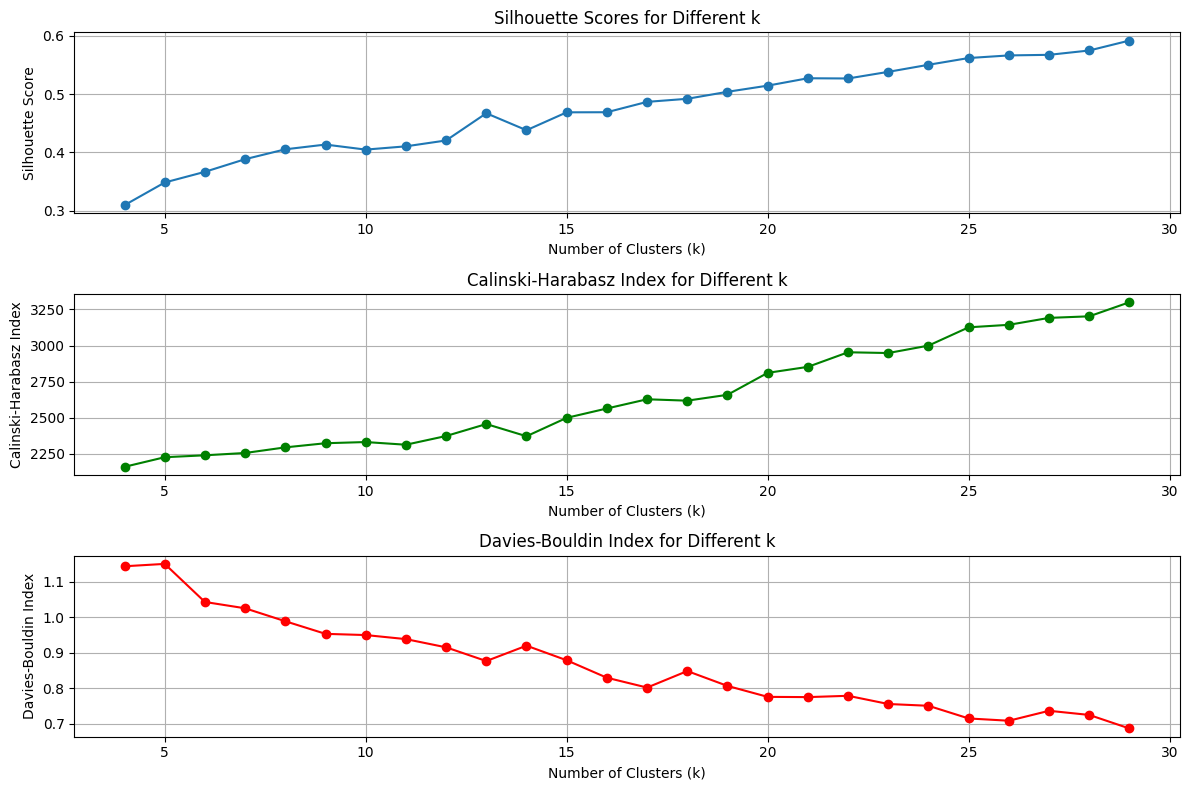

In [86]:
kmeans_ksearch_plots(three_D_representations_word)

It simply doesn't want to be clustered! We will revert to the most rudimentary methode: The ellbow

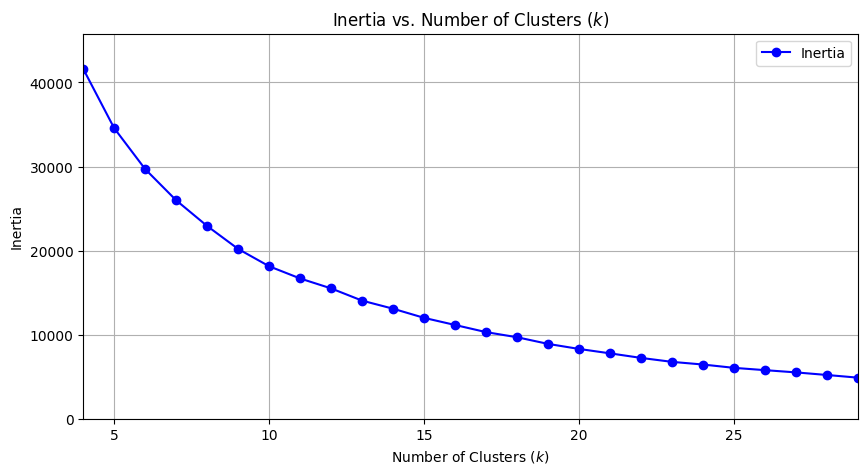

In [87]:
kmeans_ellbow_plot(three_D_representations_word)

With lots of fantasy there is an ellbow at 10
As the data is 3-D, we can just have a look...

In [88]:

def three_D_plot(data):
    # Create the figure
    fig = go.Figure()

    # Add scatter3d trace
    fig.add_trace(go.Scatter3d(
        x=data[:, 0],  # X coordinates
        y=data[:, 1],  # Y coordinates
        z=data[:, 2],  # Z coordinates
        mode='markers',
        marker=dict(
            size=5,  # Adjust size as needed
            opacity=0.05,  # Transparency
            color='blue'  # Optional, can be set to any color
        )
    ))

    # Set labels and layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis'
        ),
        title='Interactive 3D Scatter Plot'
    )

    # Show the plot
    fig.show()
three_D_plot(three_D_representations_word)

Well, that explains a lot...
Let's check whether the dense center in the middle might be stopwords

In [89]:
three_D_plot(three_D_representations_word_no_stopwords)

Indeed! The center seems to be a lot less densly populated...fascinating
A potential approach to filtering might be to eliminate words close to the origin

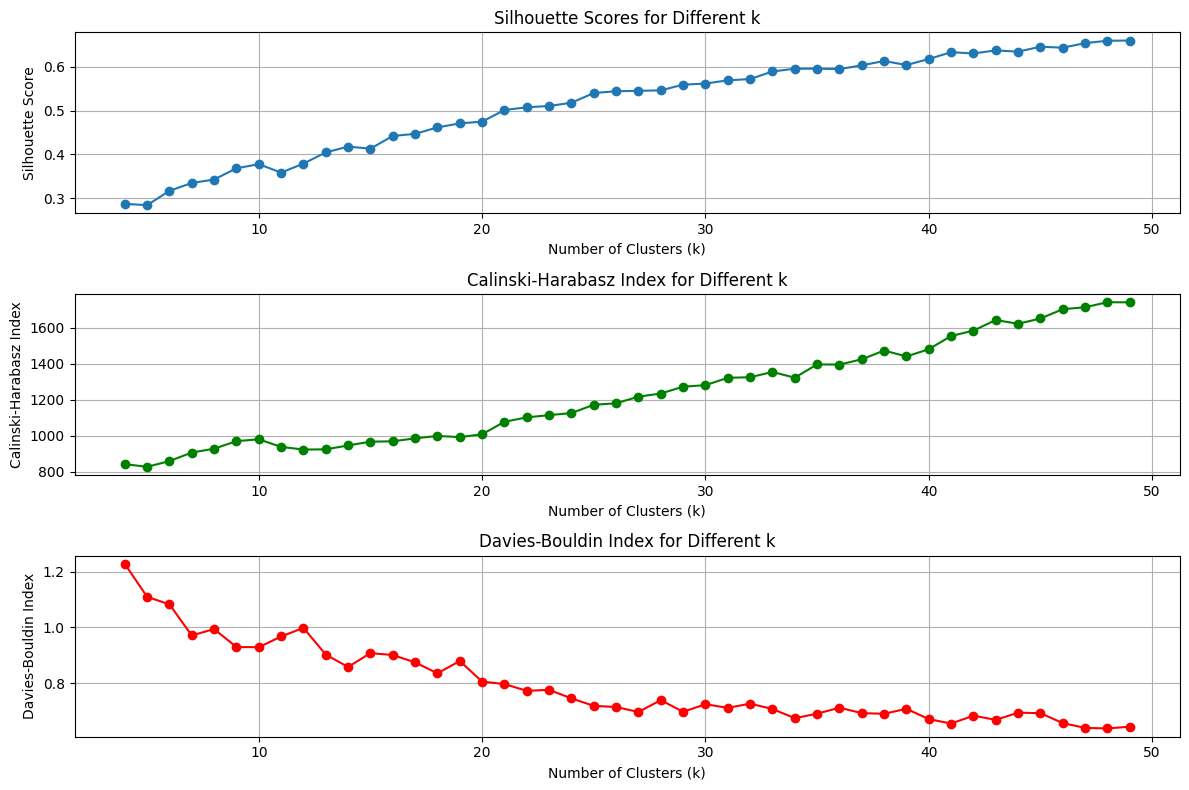

In [90]:
kmeans_ksearch_plots(three_D_representations_word_no_stopwords, k_range=range(4, 50))

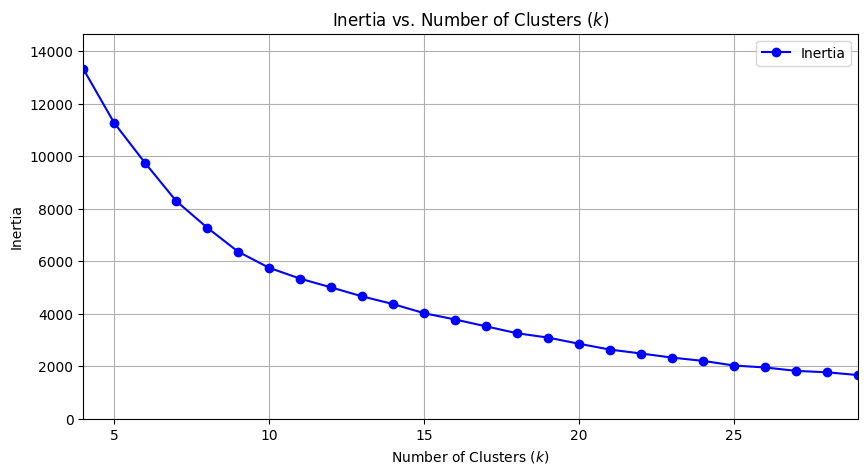

In [91]:
kmeans_ellbow_plot(three_D_representations_word_no_stopwords)

Not particularly clearer honestly. Let's try with less compressed data in 10-D

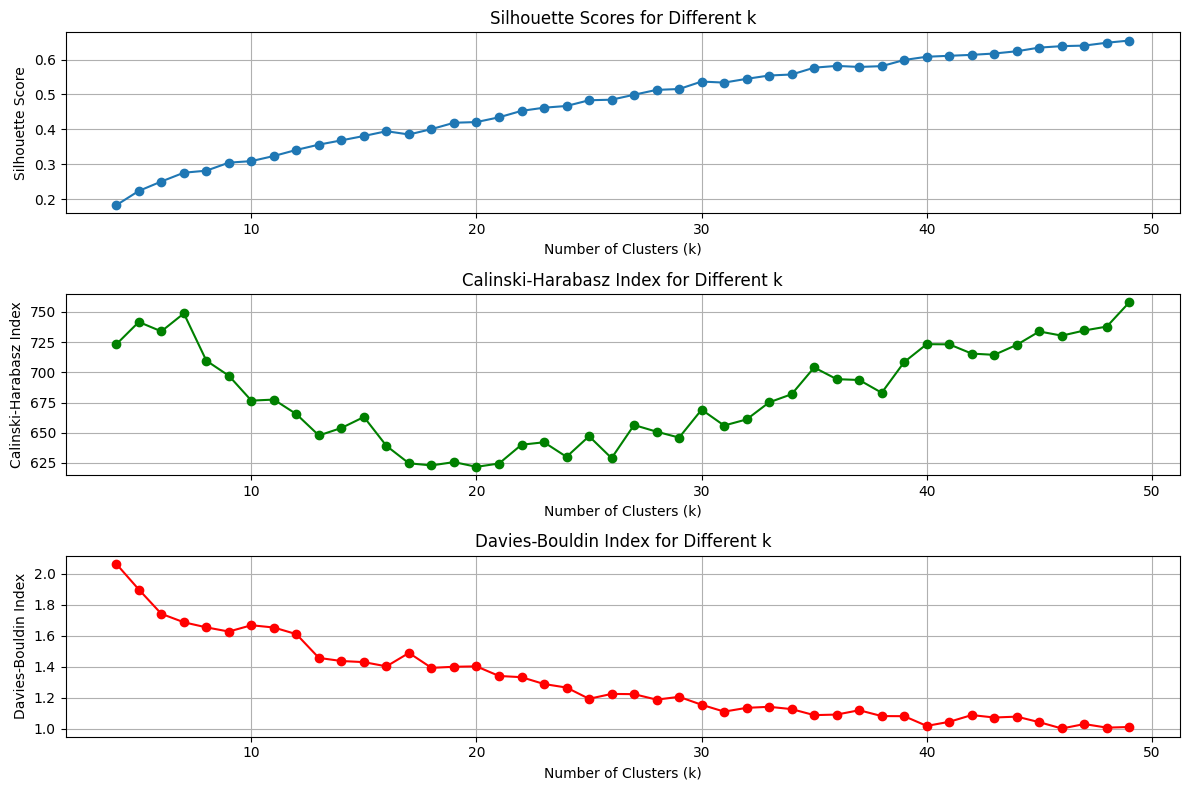

In [92]:
kmeans_ksearch_plots(ten_D_representations_word, k_range=range(4, 50))

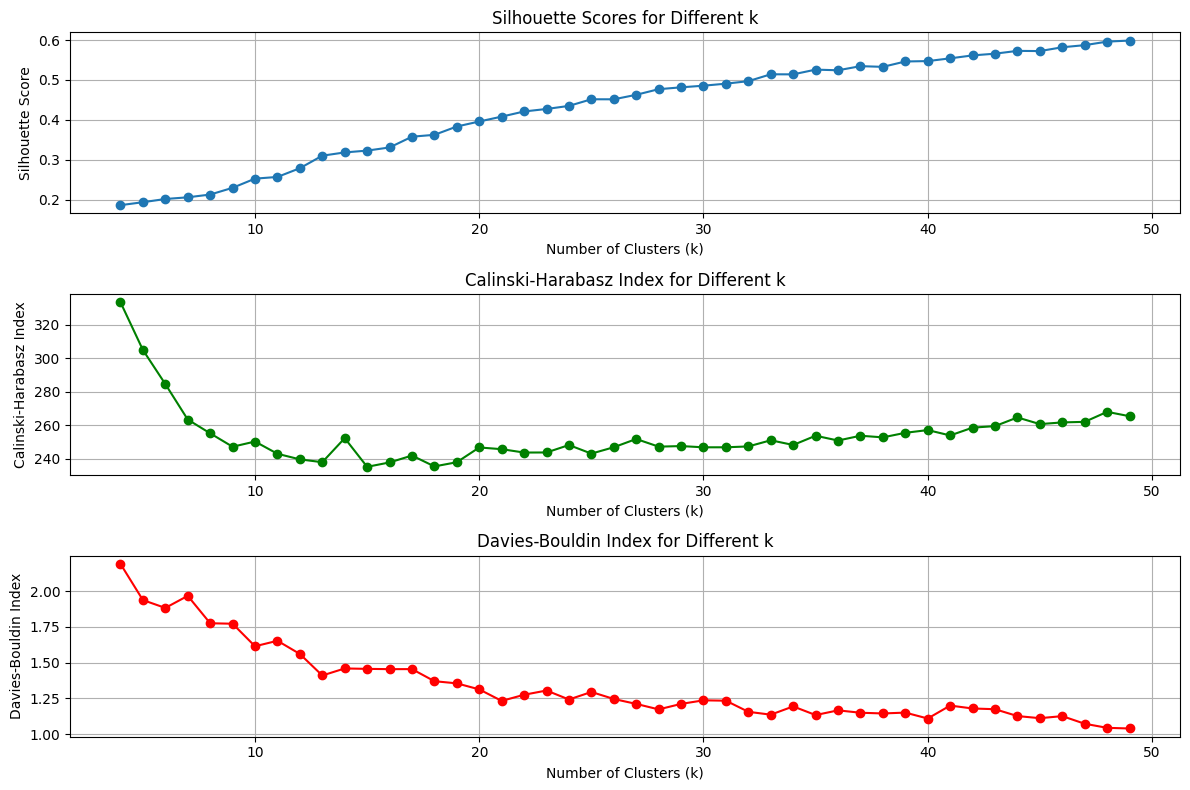

In [93]:
kmeans_ksearch_plots(ten_D_representations_word_no_stopwords, k_range=range(4, 50))

No improvement! The CHI starts behaving weirdly as well. 3 Dimensions seem to be working fine for our purpose.
Let's look at the sentence level

In [94]:
three_D_plot(three_D_representations_sentence)

Just homogenous goo...sadly

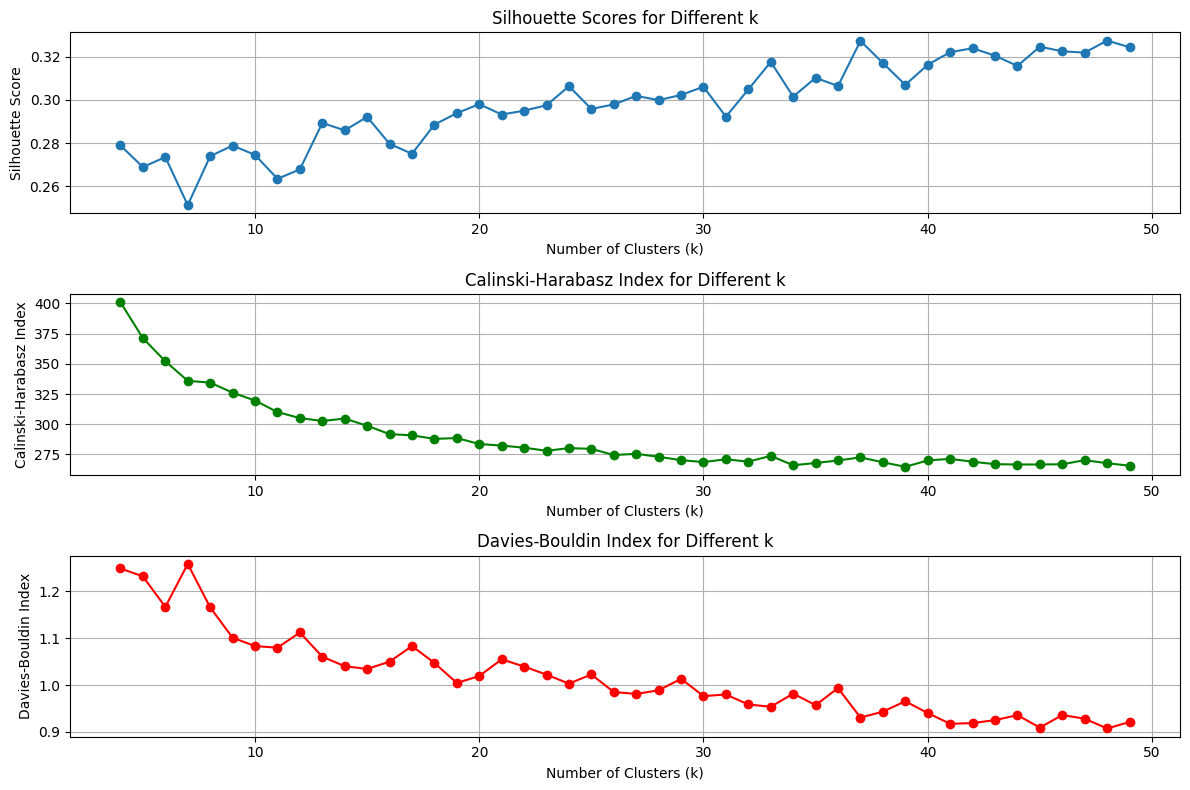

In [95]:
kmeans_ksearch_plots(three_D_representations_sentence, k_range=range(4, 50))

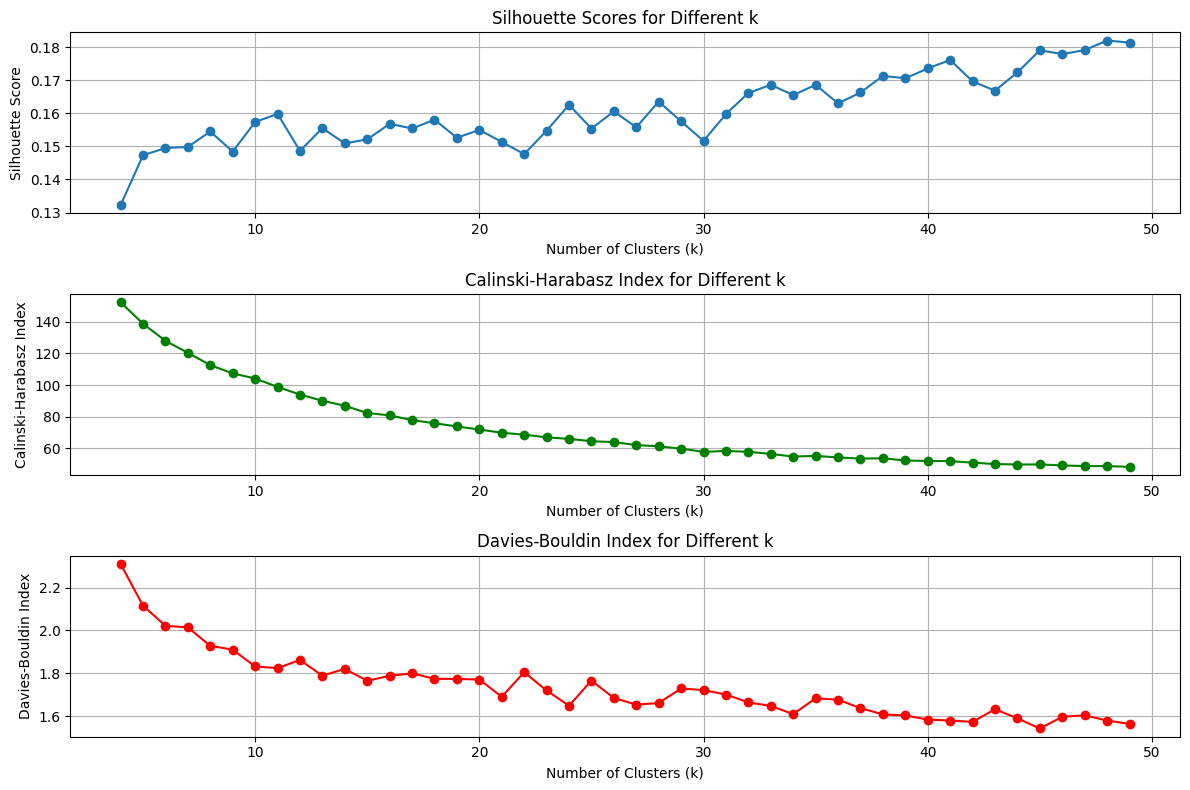

In [96]:
kmeans_ksearch_plots(ten_D_representations_sentence, k_range=range(4, 50))

It only get's worse with an increase in dimensions. The ellbow-plots were omitted, cause they look horrible. 

For sentence level data, there seem to be no distinct clusters in the data when compressed using an Autoencoder
Word level should definetly attempted, we will do a qualitative analysis later
We will try with PCA-compressed data

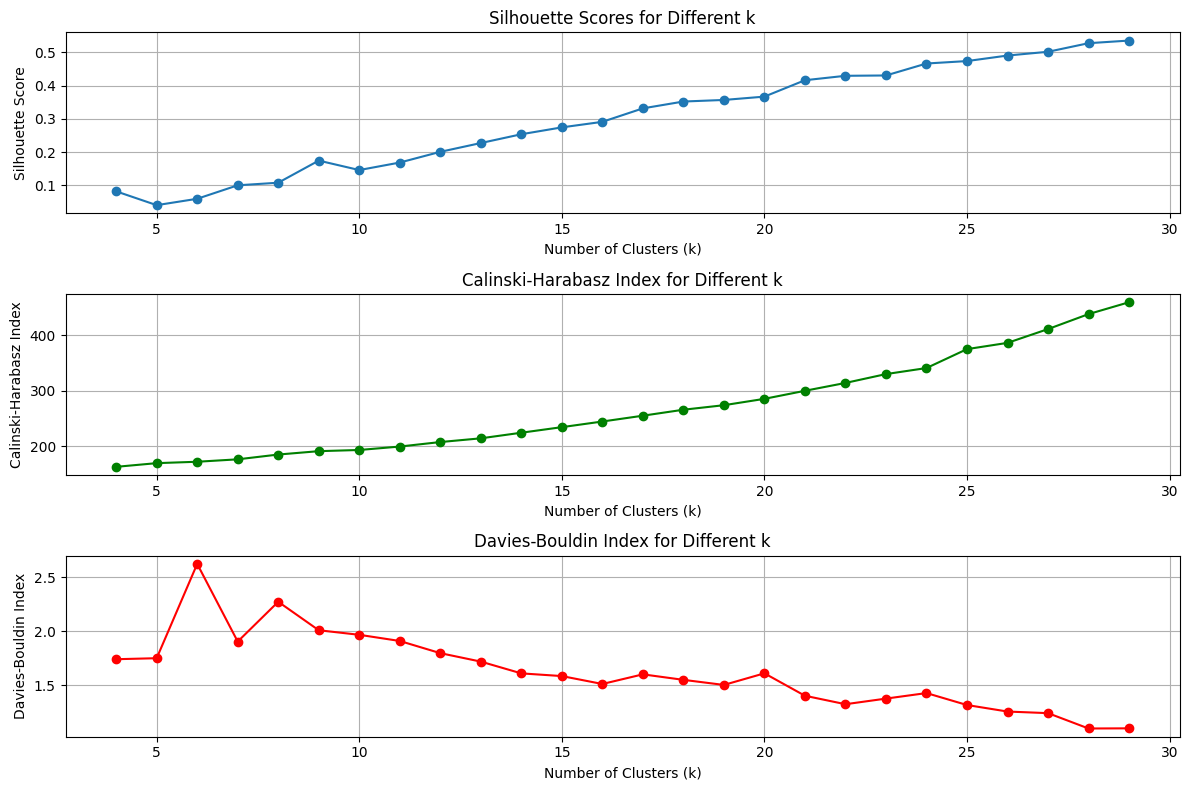

In [97]:
kmeans_ksearch_plots(X30D_word)

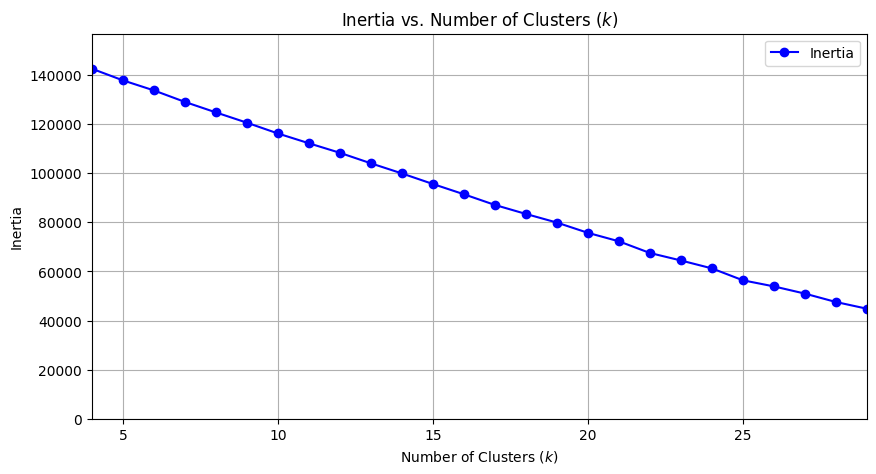

In [98]:
kmeans_ellbow_plot(X30D_word)

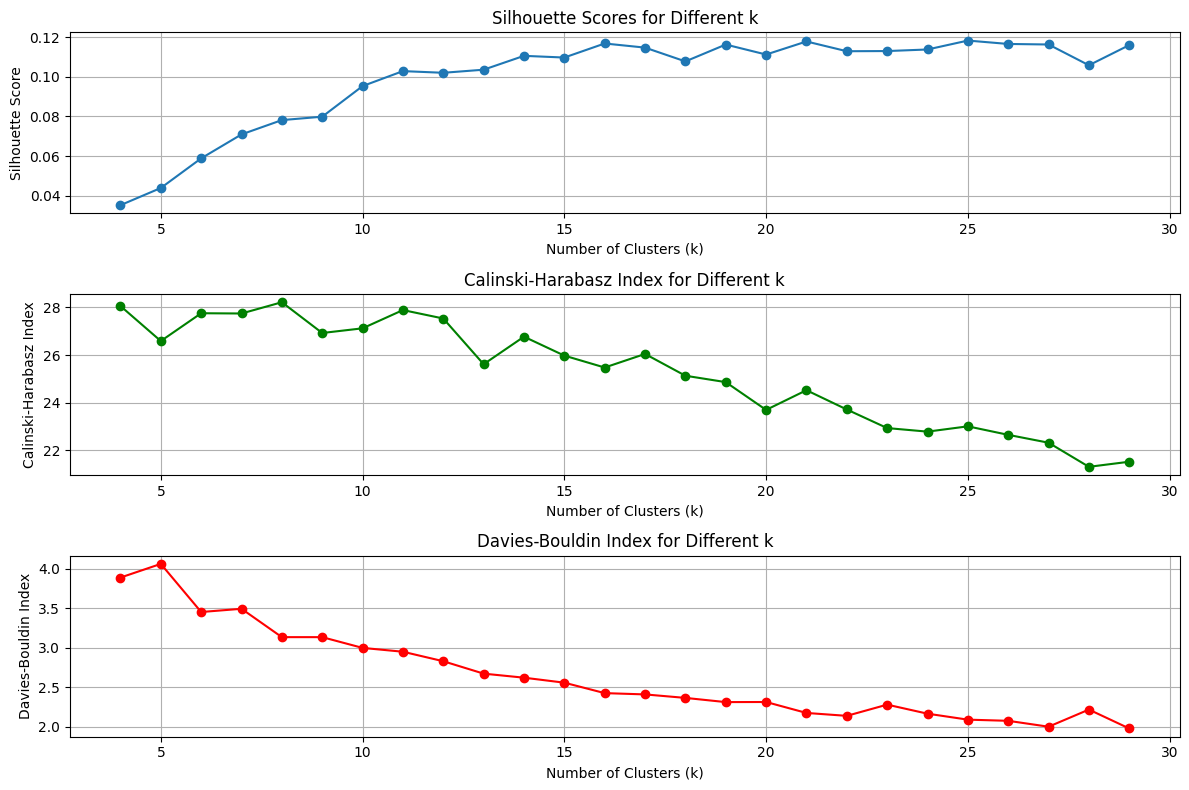

In [99]:
kmeans_ksearch_plots(X30D_sentence)

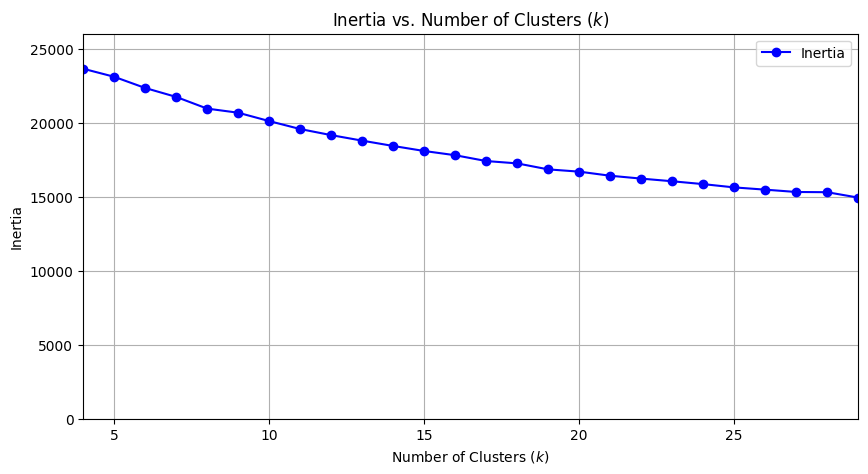

In [100]:
kmeans_ellbow_plot(X30D_sentence)

**Conclusion**: encoder-compressed data for words is worth a try and looks reasonably better.
10 Clusters for data including stopwords will be analyzed more closesly

We will now attempt 
* a qualitative evaluation of clustering
* filtering based on the distance to the origin
* Look at words that score high and low on our three dimensions

In [101]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=40, random_state=42).fit(three_D_representations_word)
wlf_sw['label'] = kmeans.labels_
wlf_sw[["dim_1","dim_2","dim_3"]] = pd.DataFrame(three_D_representations_word.tolist(), index=word_embeddings_with_stopwords.index)


# Retrieve cluster centers
cluster_centers = kmeans.cluster_centers_

# Assign distinct colors for each cluster
cluster_colors = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 1.0)' 
                  for c in plt.cm.tab10(np.linspace(0, 1, n_clusters))]  # Full opacity for legend visibility
wlf_sw['color'] = wlf_sw['label'].apply(lambda x: f'rgba({int(plt.cm.tab10(x / n_clusters)[0] * 255)}, '
                                              f'{int(plt.cm.tab10(x / n_clusters)[1] * 255)}, '
                                              f'{int(plt.cm.tab10(x / n_clusters)[2] * 255)}, 0.7)')

# Create a 3D scatter plot
fig = go.Figure()

# Scatter plot for the data points
for i in range(n_clusters):
    cluster_data = wlf_sw[wlf_sw['label'] == i]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['dim_1'],
        y=cluster_data['dim_2'],
        z=cluster_data['dim_3'],
        mode='markers',
        marker=dict(size=4, color=cluster_colors[i], opacity=0.6),
        name=f'Cluster {i} Data'
    ))

# Scatter plot for the cluster centers with distinct colors
fig.add_trace(go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(size=7, color=cluster_colors, symbol='x', line=dict(width=2, color='black')),
    name='Cluster Centers'
))

# Update layout
fig.update_layout(
    title='3D Scatter Plot with KMeans Clusters',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    legend=dict(itemsizing='constant'),
    width=1200,  # Set initial plot width
    height=800   # Set initial plot height
)

fig.show()

wlf_sw = wlf_sw.drop("color", axis=1)

Lets look at our top contenders for each cluster (e.g. the points closest to the centroids)

In [114]:

wlf_sw_uniques = wlf_sw.drop_duplicates(subset=["Word"])
# List to store closest points for each cluster
closest_points = []

# Iterate over each cluster
for i in range(n_clusters):
    # Get data points for the current cluster (filtered by 'label')
    cluster_data = wlf_sw_uniques[wlf_sw_uniques['label'] == i]
    
    # Compute the Euclidean distances from each data point to the current cluster center
    distances = cdist(cluster_data[['dim_1', 'dim_2', 'dim_3']], [kmeans.cluster_centers_[i]])
    
    # Get indices of the 10 closest points to the current cluster center
    closest_indices = np.argsort(distances.flatten())[:10]
    
    # Append the closest points to the list (use iloc to select by indices)
    closest_points.append(cluster_data.iloc[closest_indices])

# Combine the closest points from all clusters into a single DataFrame
closest_points_df = pd.concat(closest_points, ignore_index=True)

# Drop duplicate rows if any (just to be safe)
closest_points_df = closest_points_df.drop_duplicates()

# Display the resulting DataFrame with closest points
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
print(closest_points_df)

   Speaker          Word  label     dim_1     dim_2     dim_3
0       P1          sein      0  2.960700 -3.021924  2.845222
1       P2         Sieht      0  2.244025 -3.256087  0.404083
2       P1         sehen      0  1.399439 -3.278549  0.891230
3       P4       schauen      0  1.413070 -3.102962  0.477247
4       P1          sich      0  1.680792 -1.435197  1.068143
5       P1     anschauen      0  1.083606 -3.236195  0.684818
6       P3        werden      0  0.734086 -2.471870  2.165778
7       P5        siehst      0  2.139345 -3.291366 -0.158196
8       P5        Siehst      0  2.015749 -3.358346 -0.110291
9       P1        Siehts      0  1.750071 -2.878969 -0.127570
10      P1           der      1  3.124661  0.405985 -4.597890
11      P2           los      1  1.631266  0.238880 -4.266479
12      P4           von      1  1.318405  0.898861 -2.950902
13      P1           ihn      1  1.542854  0.297535 -4.568173
14      P3            du      1  3.111614  2.180714 -2.789002
15      

Let's check my hunch earlier and look at the words closest to center, might they be irrelevant?

In [120]:
# Calculate the center (mean) of dim_1, dim_2, dim_3
center = wlf_sw_uniques[['dim_1', 'dim_2', 'dim_3']].mean()

# Calculate the Euclidean distances from each row to the center
distances = cdist(wlf_sw_uniques[['dim_1', 'dim_2', 'dim_3']], [center])

# Add the distances as a new column to the DataFrame
wlf_sw_uniques['Distance_to_Center'] = distances

# Sort the DataFrame by the 'Distance_to_Center' and select the closest 20 observations
closest_20 = wlf_sw_uniques[["Word","Distance_to_Center"]].nsmallest(20, 'Distance_to_Center').reset_index(drop=True)

# Display the resulting DataFrame with the 20 closest observations
print(closest_20)

            Word  Distance_to_Center
0       scheinen            0.160039
1   frustrierend            0.211630
2          Chaos            0.237504
3           Frag            0.267644
4          hören            0.285737
5             äh            0.287530
6             ab            0.301040
7           Würd            0.302782
8           Zeig            0.328259
9            ähm            0.362603
10          Grad            0.370864
11        leider            0.388356
12         Sorge            0.389724
13    verwirrend            0.394550
14       dämlich            0.402226
15          warn            0.424262
16         probi            0.432270
17    Verwechsel            0.435397
18   verwechseln            0.446939
19        nerven            0.456840


And finally the words scoring highest among each of the three dimensions

In [121]:
# Sorting by each dimension and selecting the top 15 words
top_15_dim_1 = wlf_sw_uniques.nlargest(15, 'dim_1')[['Word', 'dim_1']].reset_index(drop=True)
top_15_dim_2 = wlf_sw_uniques.nlargest(15, 'dim_2')[['Word', 'dim_2']].reset_index(drop=True)
top_15_dim_3 = wlf_sw_uniques.nlargest(15, 'dim_3')[['Word', 'dim_3']].reset_index(drop=True)

# Display the results
print("Top 15 words for dim_1:")
print(top_15_dim_1)

print("\nTop 15 words for dim_2:")
print(top_15_dim_2)

print("\nTop 15 words for dim_3:")
print(top_15_dim_3)

Top 15 words for dim_1:
     Word     dim_1
0   Farbe  4.777930
1   blaue  4.539069
2    blau  4.530855
3    Blau  4.498879
4     rot  4.410572
5     seh  3.504626
6    gelb  3.420630
7   gelbe  3.257029
8    pink  3.255280
9    Pink  3.133394
10    der  3.124661
11     du  3.111614
12   grün  3.013326
13   sein  2.960700
14     um  2.827138

Top 15 words for dim_2:
      Word     dim_2
0      ich  5.033186
1      ein  4.359693
2       um  4.317767
3    einer  4.127495
4   einzig  3.975738
5   einmal  3.933791
6      nur  3.049268
7     mein  3.035866
8     aber  2.986178
9   Grünes  2.965591
10      an  2.949871
11      en  2.927711
12      in  2.850233
13    mich  2.812464
14    rein  2.793166

Top 15 words for dim_3:
        Word     dim_3
0        für  5.289720
1        bei  4.999080
2        mit  4.370612
3       dazu  4.249066
4       aber  3.775403
5         zu  3.572228
6      gelbe  3.397452
7       gelb  3.339807
8        und  3.031421
9   trotzdem  3.004995
10       auf  2.9